## 2.1 Source

### 2.1.1 Connecting to the database 

This project uses a structured SQLite database (org_compliance_data.db) as its primary data source.
The database contains multiple tables describing departmental characteristics, compliance-related metrics, and reference information.

We establish a connection to the database and inspect its structure to understand the available tables and their roles within the project.

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from sklearn.metrics import confusion_matrix

#connect to the SQLite database

db = sqlite3.connect('data/org_compliance_data.db')

# Query to get the list of tables in the database
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", db)


### 2.1.2 Inspecting the Database Structure

Before selecting the dataset for analysis, we examine all available tables in the database.
This step helps identify which tables are suitable for modeling, which serve as references, and which provide contextual or auxiliary information.

For each table, a small preview is displayed to understand its schema and content.

In [2]:
#available tables in the database
print(tables)

#first rows of the each table
for name in tables["name"]:
    print(f"table: {name}")
    preview = pd.read_sql(f"SELECT * FROM {name} LIMIT 5;", db)
    print(preview)
    

                       name
0               departments
1  risk_summary_by_division
2     high_risk_departments
3           data_dictionary
table: departments
     dept_id                   dept_name           dept_category  \
0  DEPT-1620             Core Compliance     Financial_Reporting   
1  DEPT-1133          Digital Governance     Financial_Reporting   
2  DEPT-4917                 Central Hub  Operational_Compliance   
3  DEPT-6959  Compliance - Legacy Region     Financial_Reporting   
4  DEPT-4312      West Internal Controls     Financial_Reporting   

       division   dept_type  dept_age_years location_type team_size  \
0  Corporate_HQ  Operations             8.0        Remote     Large   
1  Corporate_HQ  Compliance             8.0         Urban     Large   
2          None        None             NaN          None      None   
3  Corporate_HQ     Support             8.0         Urban     Large   
4  Corporate_HQ  Operations             6.0         Urban     Small   

  rep

### 2.1.3 Loading the Main Department-Level Dataset

The departments table is loaded as the primary analytical dataset.
This table contains department-level operational, reporting, organizational, and risk-related features that form the basis for all subsequent analysis and modeling steps.

We inspect its structure, data types, and summary statistics to ensure that it is suitable for machine learning tasks.

In [3]:
#Loading the departement table / possible main table
departments = pd.read_sql("SELECT * FROM departments", db)
departments.head()

#inspecting the departments table
departments.info()
departments.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   dept_id                          709 non-null    object 
 1   dept_name                        709 non-null    object 
 2   dept_category                    709 non-null    object 
 3   division                         455 non-null    object 
 4   dept_type                        413 non-null    object 
 5   dept_age_years                   411 non-null    float64
 6   location_type                    410 non-null    object 
 7   team_size                        409 non-null    object 
 8   reporting_structure              413 non-null    object 
 9   manager_experience_level         413 non-null    float64
 10  supervisor_experience_level      409 non-null    float64
 11  primary_function                 416 non-null    object 
 12  secondary_function    

,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
count,709,709,709,455,413,411.000000,410,409,413,413.000000,...,410.000000,406.000000,416.000000,410.000000,411.000000,412.000000,430.000000,435.000000,433.000000,409.000000
unique,682,454,3,2,6,NaN,4,3,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,DEPT-9694,Tactical Quality Assurance,Financial_Reporting,Corporate_HQ,Support,NaN,Urban,Large,Centralized,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3,5,419,428,206,NaN,304,272,332,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,6.802920,NaN,NaN,NaN,2.624697,...,3.190244,3.086207,1.673077,2.360976,3.491484,5.114078,61.707209,62.113333,63.955427,26.783619
std,NaN,NaN,NaN,NaN,NaN,1.915939,NaN,NaN,NaN,1.164637,...,1.061854,1.190479,1.112404,1.361877,1.447218,6.514748,12.927911,13.338300,13.693694,19.144580
min,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,30.000000,0.000000,10.000000
25%,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,2.000000,...,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,54.125000,54.900000,55.000000,12.000000
50%,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,3.000000,...,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,60.000000,60.000000,65.000000,20.000000
75%,NaN,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,4.000000,...,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,70.000000,70.000000,75.000000,34.000000


### 2.1.4 Understanding Feature Definitions

To correctly interpret the variables used in the analysis, we inspect the data_dictionary table.
This table provides definitions, data types, and descriptions for each feature, supporting informed preprocessing decisions such as encoding, scaling, and feature selection.

In [4]:
#inspecting the different dict
dtype_dict = pd.read_sql("SELECT * FROM data_dictionary", db)
dtype_dict.head(10)

,table_name,field_name,data_type,description
0,departments,dept_id,string,Unique department identifier
1,departments,dept_name,string,Department name
2,departments,dept_category,string,Primary compliance category (Financial_Reporti...
3,departments,division,string,"Organizational division (Corporate_HQ, Regiona..."
4,departments,dept_type,string,"Department type (Operations, Support, Complian..."
5,departments,dept_age_years,integer,Age of department in years since establishment
6,departments,location_type,string,"Geographic location type (Urban, Remote, Subur..."
7,departments,team_size,string,"Team size category (Small, Medium, Large)"
8,departments,reporting_structure,string,"Reporting hierarchy (Centralized, Autonomous, ..."
9,departments,manager_experience_level,integer,Manager experience level (0=none to 4=extensive)


### Explanation of Database Tables

---

departments

This is the main table used in the project and contains comprehensive department-level data, including operational metrics, compliance-related indicators, reporting behavior, managerial experience, training activities, and historical infractions.
It serves as the primary analytical dataset and provides the row-level observations required for modeling compliance risk.

---

risk_summary_by_division

This table contains aggregated, division-level risk indicators (e.g., Corporate HQ, Regional Operations).
While it is not used as an input for the machine learning models, it provides useful contextual information that may support descriptive analysis and high-level interpretation of risk patterns across organizational units.

---

high_risk_departments

This table lists departments that are classified as high risk based on external criteria or prior evaluations.
It is not used as a source of predictive features, but rather as an external reference to construct the binary target variable (is_high_risk) used in the supervised learning task.

---

data_dictionary

The data dictionary provides detailed definitions, data types, and descriptions for all variables in the database.
It supports accurate feature interpretation and informed preprocessing decisions, such as identifying numerical versus categorical variables and determining appropriate handling strategies within the modeling pipeline.

---

Main Dataset for Analysis

The departments table serves as the primary dataset for this project, as it includes all department-level features required for compliance-focused machine learning analysis.
Other tables are not directly used for model training but contribute to labeling, interpretation, and contextual understanding of the data.

### 2.2 Data Cleaning

Missing Value Analysis

Before applying any preprocessing steps, we analyze the presence and distribution of missing values across all department-level features.
This analysis allows us to understand whether missingness is systematic or sparse and to select appropriate imputation strategies without discarding valuable observations.

A summary table is created to report both the absolute count and the percentage of missing values per feature.

In [5]:
#analysis of missing value
miss_counts = departments.isnull().sum()
miss_percent = (departments.isnull().mean() * 100).round(2)

#create a table to summarize missing values
miss_table = pd.DataFrame({
    "miss_counts": miss_counts,
    "miss_percent": miss_percent
}).sort_values(by="miss_percent", ascending=False)

miss_table

,miss_counts,miss_percent
digital_systems,304,42.88
external_interactions_frequency,303,42.74
interdept_collaboration_score,303,42.74
oversight_body,303,42.74
violations_past_3years,303,42.74
onboarding_program,302,42.60
overall_risk_score,300,42.31
training_hours_quarterly,300,42.31
team_size,300,42.31
external_partnerships,300,42.31


### 2.2.0 Missingness Pattern Visualization

We visualize missingness patterns to identify structured gaps in the dataset.
This supports later discussion of surveillance bias, where high-risk departments may be monitored more intensively and thus have more complete records.

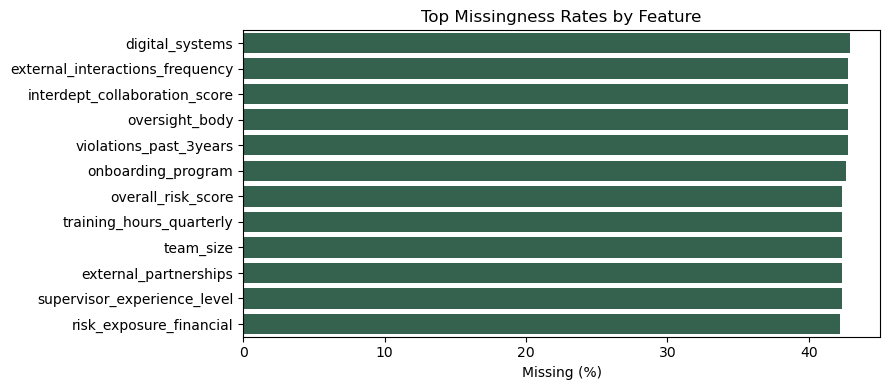

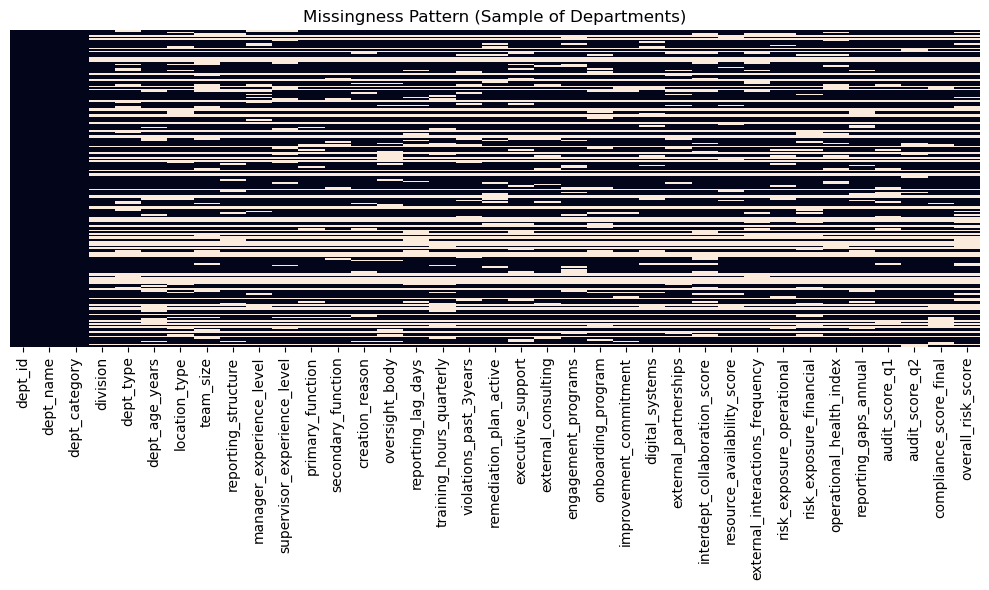

Saved: images/missingness_top_features.png
Saved: images/missingness_matrix_sample.png


In [6]:

images_dir = "images"
os.makedirs(images_dir, exist_ok=True)

missing_plot_df = (
    miss_table[miss_table["miss_percent"] > 0]
    .head(12)
    .reset_index()
    .rename(columns={"index": "feature"})
)

plt.figure(figsize=(9, 4))
sns.barplot(data=missing_plot_df, x="miss_percent", y="feature", color="#2d6a4f")
plt.title("Top Missingness Rates by Feature")
plt.xlabel("Missing (%)")
plt.ylabel("")
plt.tight_layout()
miss_bar_path = os.path.join(images_dir, "missingness_top_features.png")
plt.savefig(miss_bar_path, dpi=300)
plt.show()
plt.close()

sampled = departments.sample(n=min(len(departments), 200), random_state=42)
plt.figure(figsize=(10, 6))
sns.heatmap(sampled.isnull(), cbar=False, yticklabels=False)
plt.title("Missingness Pattern (Sample of Departments)")
plt.tight_layout()
miss_matrix_path = os.path.join(images_dir, "missingness_matrix_sample.png")
plt.savefig(miss_matrix_path, dpi=300)
plt.show()
plt.close()

print("Saved:", miss_bar_path)
print("Saved:", miss_matrix_path)


### 2.2.1 Temporary Imputation for EDA Visualizations

To enable stable and interpretable visualizations during exploratory analysis, missing values are temporarily imputed on a dedicated EDA copy of the dataset (`eda_df`).

The strategy is as follows:
- Numerical features are filled using the median, which is robust to skewness and outliers.
- Categorical features are filled using the most frequent category (mode).

**Important:**  
This imputation is performed **exclusively for EDA purposes** and is not used in any model training, validation, or testing step.

All modeling-related imputation is handled separately inside the machine learning pipeline and is fitted only on the training data to avoid information leakage.

In [7]:
# 2.2.1 Cleaning for EDA ONLY (avoid leakage)
# We create a separate cleaned copy for visualization / exploratory analysis.

eda_df = departments.copy()

# Separate numerical and categorical columns (based on raw schema)
num_col = eda_df.select_dtypes(include=["float64", "int64"]).columns
categorical_col = eda_df.select_dtypes(include=["object"]).columns

# Fill missing values for EDA plots (median for numeric, mode for categorical)
for col in num_col:
    eda_df[col] = eda_df[col].fillna(eda_df[col].median())

for col in categorical_col:
    # mode() can be empty if column is all-NaN, guard for safety
    mode_series = eda_df[col].mode()
    if len(mode_series) > 0:
        eda_df[col] = eda_df[col].fillna(mode_series.iloc[0])

# Check remaining missing values in the EDA copy
eda_df.isnull().sum().sum()


0

### 2.3 Outlier analysis
Outliers are identified using the Interquartile Range (IQR) method, where values are flagged if they fall below
Q1 − 1.5 × IQR or above Q3 + 1.5 × IQR.

Rather than removing outliers, we quantify their presence per feature.
This decision reflects the domain context: extreme values may correspond to genuinely risky or atypical departments and therefore should not be automatically excluded.

The analysis is used for interpretative purposes rather than aggressive data trimming.

In [8]:
num_columns = departments.select_dtypes(include=["float64", "int64"]).columns

outliers = {}

for col in num_columns:
    Q1 = departments[col].quantile(0.25)
    Q3 = departments[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_condition = departments[(departments[col] < lower_bound) | (departments[col] > upper_bound)][col]
    
    outliers[col] = len(outlier_condition)

outlier = pd.DataFrame.from_dict(outliers, orient='index', columns=['outlier_count'])
outlier.sort_values(by='outlier_count', ascending=False)

,outlier_count
digital_systems,88
violations_past_3years,75
remediation_plan_active,72
improvement_commitment,56
external_consulting,51
risk_exposure_operational,40
reporting_lag_days,36
resource_availability_score,26
dept_age_years,22
overall_risk_score,21


### 2.4 Identification of Categorical Variables

Categorical features are identified based on their data types.

Identifier variables such as `dept_id` and `dept_name` are explicitly excluded, as they do not carry predictive information and may introduce leakage if encoded.

At this stage, no encoding is applied for modeling purposes.  
All categorical transformations required for machine learning are performed later inside the preprocessing pipeline.

In [9]:
# 2.4 Encoding (EDA ONLY)
# We one-hot encode categorical variables for exploratory inspection.
# Modeling will handle encoding inside the ML pipeline (train-only fit).

cat_cols = eda_df.select_dtypes(include=["object"]).columns
cols_excluded = ["dept_id", "dept_name"]
cat_encoded = [col for col in cat_cols if col not in cols_excluded]

eda_df_encoded = pd.get_dummies(eda_df, columns=cat_encoded, drop_first=True)

display(eda_df_encoded.head())
eda_df_encoded.info()


,dept_id,dept_name,dept_age_years,manager_experience_level,supervisor_experience_level,reporting_lag_days,training_hours_quarterly,violations_past_3years,remediation_plan_active,executive_support,...,secondary_function_Operations,secondary_function_Other,secondary_function_Technology,creation_reason_Innovation,creation_reason_Merger,creation_reason_Regulation,creation_reason_Restructuring,oversight_body_Compliance_Officer,oversight_body_External_Auditor,oversight_body_Internal_Audit
0,DEPT-1620,Core Compliance,8.0,2.0,2.0,1.0,40.0,0.0,1.0,0.0,...,False,True,False,False,False,False,True,False,False,True
1,DEPT-1133,Digital Governance,8.0,2.0,2.0,1.0,20.0,1.0,0.0,1.0,...,False,False,False,False,False,True,False,False,False,True
2,DEPT-4917,Central Hub,7.0,3.0,2.0,1.0,40.0,0.0,0.0,1.0,...,False,True,False,False,False,True,False,False,False,True
3,DEPT-6959,Compliance - Legacy Region,8.0,4.0,3.0,1.0,60.0,0.0,0.0,1.0,...,False,True,False,False,False,True,False,False,False,True
4,DEPT-4312,West Internal Controls,6.0,1.0,2.0,2.0,40.0,0.0,0.0,1.0,...,False,True,False,False,False,False,True,False,False,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709 entries, 0 to 708
Data columns (total 61 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   dept_id                               709 non-null    object 
 1   dept_name                             709 non-null    object 
 2   dept_age_years                        709 non-null    float64
 3   manager_experience_level              709 non-null    float64
 4   supervisor_experience_level           709 non-null    float64
 5   reporting_lag_days                    709 non-null    float64
 6   training_hours_quarterly              709 non-null    float64
 7   violations_past_3years                709 non-null    float64
 8   remediation_plan_active               709 non-null    float64
 9   executive_support                     709 non-null    float64
 10  external_consulting                   709 non-null    float64
 11  engagement_programs

### 2.4.1 Encoding Strategy (Modeling Stage)

Although categorical variables are identified at this stage, one-hot encoding is **not applied directly to the dataset**.

Instead, categorical encoding is performed inside the machine learning pipeline using a `OneHotEncoder`, which is fitted exclusively on the training data.

This design:
- prevents information leakage,
- ensures robustness to unseen categories,
- guarantees consistent preprocessing across train, validation, and test sets.

In [10]:
# Last check (EDA encoded)
eda_df_encoded.select_dtypes(include=["object"])


,dept_id,dept_name
0,DEPT-1620,Core Compliance
1,DEPT-1133,Digital Governance
2,DEPT-4917,Central Hub
3,DEPT-6959,Compliance - Legacy Region
4,DEPT-4312,West Internal Controls
...,...,...
704,DEPT-8327,Alpha Operations
705,DEPT-1235,Governance - Regional Region
706,DEPT-1852,Digital Unit
707,DEPT-8168,Digital Compliance


## 2.5 Feature Preparation

In this section, we create a stable working copy of the dataset that will be used as the basis for downstream modeling steps, while EDA is conducted on a separate copy.

At this stage:
- **No scaling is applied yet** to avoid data leakage.
- A clean copy of the departments table is created as `df`.
- A separate copy, `eda_df`, is reserved exclusively for exploratory analysis.
- Identifier columns (`dept_id`, `dept_name`) are excluded from numerical feature lists.

Actual scaling will be performed later **inside the machine learning pipeline**, after train-validation-test splitting.

In [11]:
# 2.5 Feature Preparation (NO scaling here)
# Create a stable RAW working dataframe (df) for modeling.
# IMPORTANT: df must remain raw (no global imputation/encoding/scaling).
df = departments.copy()
print("Working RAW dataframe (df) created:", df.shape)

# Identify basic column groups (used later for reporting/EDA summaries only)
id_cols = ["dept_id", "dept_name"]
numeric_cols = [c for c in df.columns if (df[c].dtype != "object") and (c not in id_cols)]

print("Example numeric columns:", numeric_cols[:10])
print("Number of numeric columns:", len(numeric_cols))


Working RAW dataframe (df) created: (709, 37)
Example numeric columns: ['dept_age_years', 'manager_experience_level', 'supervisor_experience_level', 'reporting_lag_days', 'training_hours_quarterly', 'violations_past_3years', 'remediation_plan_active', 'executive_support', 'external_consulting', 'engagement_programs']
Number of numeric columns: 25


### 2.5.1 Numerical Feature Overview

Before performing any transformation, we inspect the distributional properties of numerical variables
(mean, variance, and range).

This step serves two purposes:
- to understand scale differences across features,
- to identify skewed variables and potential outliers that may influence modeling decisions.

No transformations are applied at this stage; this is a purely descriptive inspection.

In [12]:
display(df[numeric_cols].describe().T.head(10))

,count,mean,std,min,25%,50%,75%,max
dept_age_years,411.0,6.802920,1.915939,2.0,6.0,7.0,8.0,15.0
manager_experience_level,413.0,2.624697,1.164637,0.0,2.0,3.0,4.0,4.0
supervisor_experience_level,409.0,2.398533,1.137635,0.0,2.0,2.0,3.0,4.0
reporting_lag_days,412.0,1.682039,1.019693,1.0,1.0,1.0,2.0,5.0
training_hours_quarterly,409.0,43.180929,19.728215,12.0,20.0,40.0,60.0,100.0
violations_past_3years,406.0,0.435961,1.108703,0.0,0.0,0.0,0.0,5.0
remediation_plan_active,411.0,0.175182,0.380586,0.0,0.0,0.0,0.0,1.0
executive_support,413.0,0.607748,0.488845,0.0,0.0,1.0,1.0,1.0
external_consulting,414.0,0.123188,0.329051,0.0,0.0,0.0,0.0,1.0
engagement_programs,410.0,0.519512,0.500230,0.0,0.0,1.0,1.0,1.0


## 3. Exploratory Data Analysis (EDA)

This section explores the structure and behavior of key department-level variables
using **only pre-target data**.

To avoid any form of target leakage:
- no risk labels are used,
- no audit-derived scores are included,
- no train/test split is applied.

EDA is conducted purely to understand natural data patterns and relationships.

### 3.1 Data-driven Feature Selection for EDA

Rather than manually selecting variables based on prior knowledge,
we adopt a **data-driven feature filtering strategy** for EDA.

To ensure fairness and avoid circular reasoning:
- identifier columns are removed,
- audit-related and risk-label variables are excluded,
- only numerical, pre-outcome variables are retained.

This allows us to explore structural relationships **without assuming which features are important beforehand**.

In [13]:
# 3.1 Data-driven feature selection for EDA

exclude_cols = [
    "dept_id",
    "dept_name",
    "audit_score_q1",
    "audit_score_q2",
    "compliance_score_final",
    "overall_risk_score"
]
exclude_cols = [c for c in exclude_cols if c in eda_df.columns]

numeric_cols = (
    eda_df
    .drop(columns=exclude_cols, errors="ignore")
    .select_dtypes(include=["int64", "float64"])
    .columns
    .tolist()
)

corr = eda_df[numeric_cols].corr().abs()

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "abs_corr"})
    .sort_values("abs_corr", ascending=False)
)

top_pairs = pairs.head(20)
display(top_pairs)

eda_selected_features = (
    pd.concat([top_pairs["feature_1"], top_pairs["feature_2"]])
    .value_counts()
    .head(6)
    .index
    .tolist()
)

print("EDA-selected features (correlation-based):")
print(eda_selected_features)

,feature_1,feature_2,abs_corr
204,risk_exposure_operational,risk_exposure_financial,0.503990
95,violations_past_3years,improvement_commitment,0.405046
64,reporting_lag_days,improvement_commitment,0.388146
20,manager_experience_level,supervisor_experience_level,0.385897
101,violations_past_3years,risk_exposure_operational,0.362483
206,risk_exposure_operational,reporting_gaps_annual,0.350428
58,reporting_lag_days,violations_past_3years,0.344542
70,reporting_lag_days,risk_exposure_operational,0.339510
104,violations_past_3years,reporting_gaps_annual,0.311941
173,improvement_commitment,reporting_gaps_annual,0.297753


EDA-selected features (correlation-based):
['improvement_commitment', 'reporting_lag_days', 'risk_exposure_operational', 'violations_past_3years', 'reporting_gaps_annual', 'dept_age_years']


### 3.2 Correlation Analysis (EDA-selected Features)

We analyze pairwise correlations among the EDA-selected numerical features
to identify structural relationships and potential redundancy.

This heatmap helps:
- detect strongly correlated variables,
- understand multicollinearity risks,
- guide later modeling choices (e.g., tree-based vs linear models).

Importantly, correlations are computed **without reference to the target variable**.

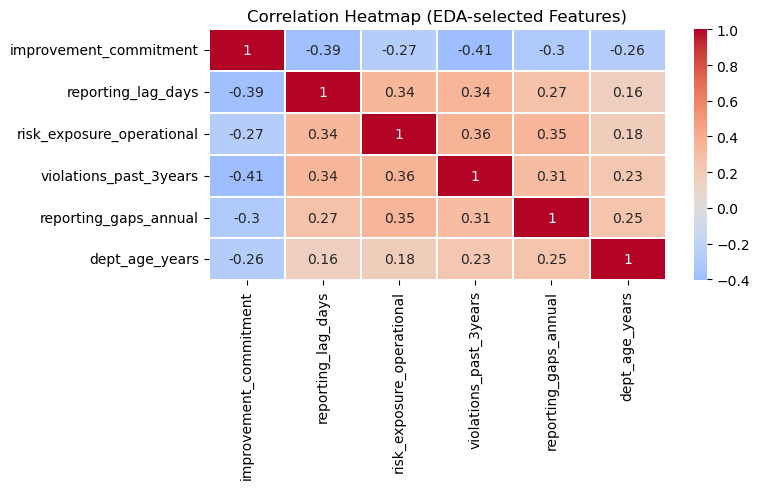

Saved: images/eda_correlation_heatmap.png


In [14]:

images_dir = "images"
os.makedirs(images_dir, exist_ok=True)

plt.figure(figsize=(8, 5))
sns.heatmap(
    eda_df[eda_selected_features].corr(numeric_only=True),
    cmap="coolwarm",
    center=0,
    linewidths=0.3,
    annot=True
)
plt.title("Correlation Heatmap (EDA-selected Features)")
plt.tight_layout()
heatmap_path = os.path.join(images_dir, "eda_correlation_heatmap.png")
plt.savefig(heatmap_path, dpi=300)
plt.show()
plt.close()

print("Saved:", heatmap_path)


### 3.3 Distribution Analysis

Histograms are used to examine the marginal distributions of EDA-selected features.

This step highlights:
- skewness and heavy tails,
- concentration of values,
- potential transformations that may be required later.

These observations inform model choice and preprocessing decisions,
but no transformations are applied at this stage.

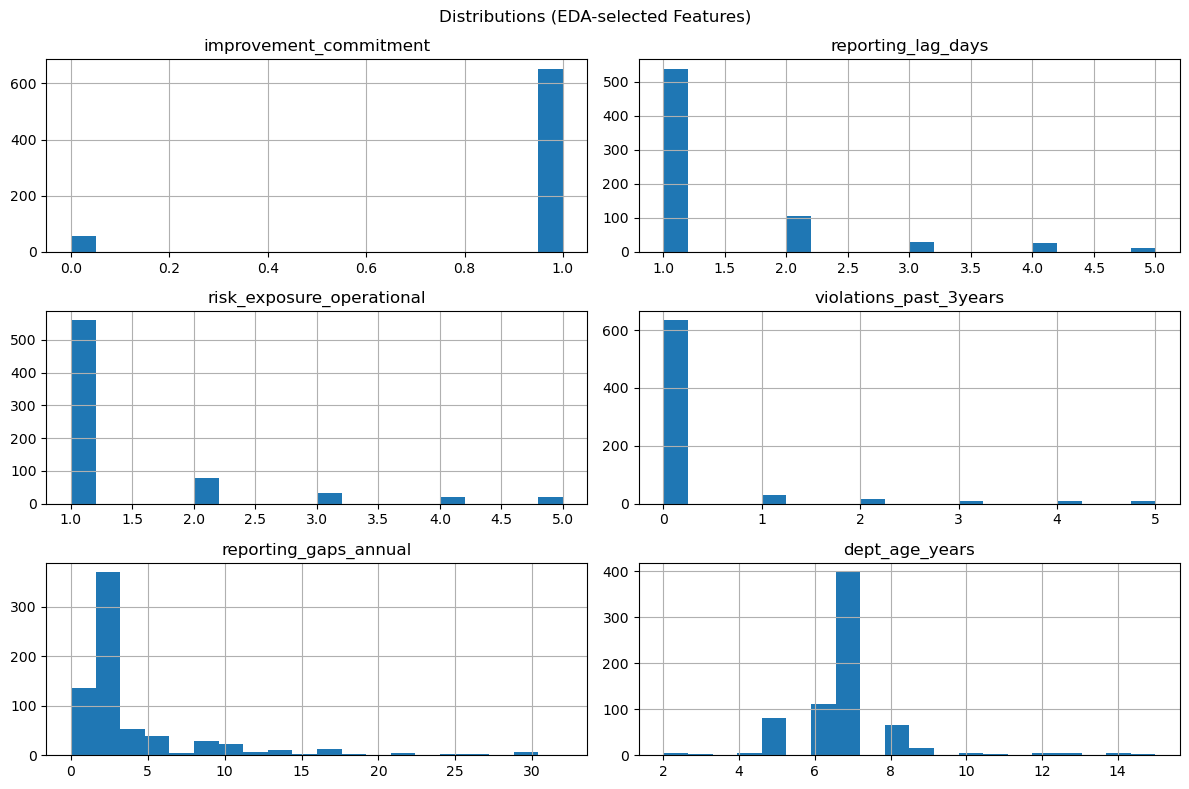

Saved: images/eda_feature_distributions.png


In [15]:

images_dir = "images"
os.makedirs(images_dir, exist_ok=True)

eda_df[eda_selected_features].hist(bins=20, figsize=(12, 8))
plt.suptitle("Distributions (EDA-selected Features)")
plt.tight_layout()
hist_path = os.path.join(images_dir, "eda_feature_distributions.png")
plt.savefig(hist_path, dpi=300)
plt.show()
plt.close()

print("Saved:", hist_path)


### 3.4 Correlation-Based Feature Grouping

To systematically group features with similar statistical behavior, we apply hierarchical clustering based on correlation distances.

The procedure:
- computes absolute pairwise correlations between EDA-selected features,
- converts correlations into a distance metric,
- applies hierarchical clustering to automatically form feature groups.

This approach allows us to:
- reduce redundancy in visualizations,
- separate features with fundamentally different distributions,
- justify grouping decisions without relying on domain assumptions or target information.

In [16]:

# hierarchical clustering of EDA-selected features
corr_sel = eda_df[eda_selected_features].corr().abs()
distance = 1 - corr_sel

# linkage expects condensed distance matrix
condensed = squareform(distance.values, checks=False)
Z = linkage(condensed, method="average")

# automatically split into 2 groups
clusters = fcluster(Z, t=2, criterion="maxclust")

feature_groups = (
    pd.DataFrame({
        "feature": eda_selected_features,
        "cluster": clusters
    })
    .sort_values("cluster")
)

feature_groups


,feature,cluster
0,improvement_commitment,1
1,reporting_lag_days,1
2,risk_exposure_operational,1
3,violations_past_3years,1
4,reporting_gaps_annual,1
5,dept_age_years,2


### 3.5 Distribution Analysis by Feature Group

For each correlation-based feature group, we visualize the distributions using violin plots.

These plots highlight:
- differences in scale and spread,
- asymmetry and outliers,
- structural heterogeneity across feature groups.

Separating features into groups improves interpretability and prevents misleading comparisons across unrelated variables.

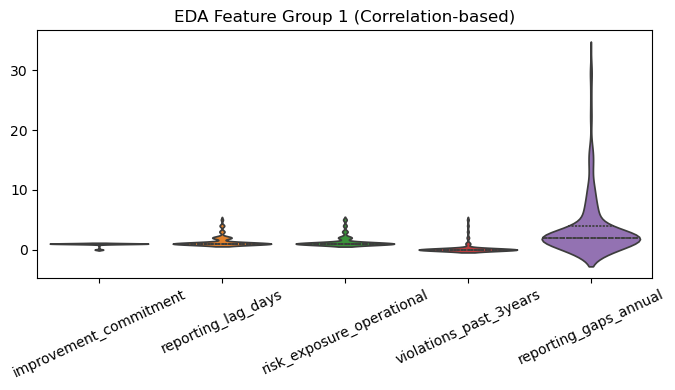

Saved: images/eda_feature_group_1.png


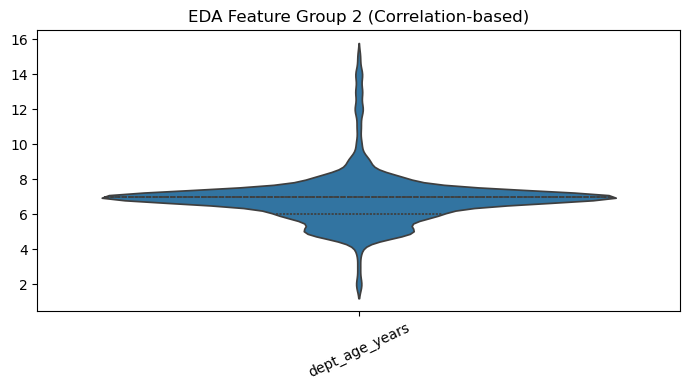

Saved: images/eda_feature_group_2.png


In [17]:

images_dir = "images"
os.makedirs(images_dir, exist_ok=True)

for c in sorted(feature_groups["cluster"].unique()):
    feats = feature_groups.loc[
        feature_groups["cluster"] == c, "feature"
    ].tolist()

    plt.figure(figsize=(7, 4))
    sns.violinplot(data=eda_df[feats], inner="quartile")
    plt.title(f"EDA Feature Group {c} (Correlation-based)")
    plt.xticks(rotation=25)
    plt.tight_layout()
    group_path = os.path.join(images_dir, f"eda_feature_group_{c}.png")
    plt.savefig(group_path, dpi=300)
    plt.show()
    plt.close()

    print("Saved:", group_path)


## 4. Modeling & Experiments

In this section, we design, train, and evaluate supervised machine learning models to classify departments as **high risk** or **not high risk**.

All modeling decisions strictly follow best practices to prevent data leakage:
- The target variable is created **before** any preprocessing.
- Train, validation, and test splits are performed **prior to scaling and encoding**.
- All preprocessing steps (imputation, scaling, encoding) are applied **inside the pipeline**, fitted only on training data.

This ensures that performance estimates are realistic and reproducible.

### 4.0 Modeling Setup & Environment

We begin by importing all required machine learning components, including:
- classification models,
- evaluation metrics,
- preprocessing tools,
- pipeline and column transformers.

An output directory is also initialized to store all figures generated during evaluation.  
The existing database connection is reused to maintain consistency across the notebook.

In [ ]:
images_dir = "images"
os.makedirs(images_dir, exist_ok=True)

print("Setup OK. Using existing DB connection: db")
print("Images dir ready:", images_dir)

Setup OK. Using existing DB connection: db
Images dir ready: images


### 4.1 Target Variable Construction

The target variable is constructed using the `high_risk_departments` table in the database.

Each department is labeled as:
- **1** if it appears in the high-risk reference table,
- **0** otherwise.

To avoid preprocessing leakage, This step starts from the raw feature dataframe (`df`), before any encoding, scaling, or statistical feature transformation is applied.

In [19]:
# --- Start from RAW dataframe (df) to avoid preprocessing leakage
# df should exist earlier as: df = departments.copy()

print("df shape at the start:", df.shape)
display(df.head(3))

# Use existing open DB connection: db
high_risk = pd.read_sql("SELECT dept_id FROM high_risk_departments;", db)

high_risk_ids = set(high_risk["dept_id"])


df shape at the start: (709, 37)


,dept_id,dept_name,dept_category,division,dept_type,dept_age_years,location_type,team_size,reporting_structure,manager_experience_level,...,resource_availability_score,external_interactions_frequency,risk_exposure_operational,risk_exposure_financial,operational_health_index,reporting_gaps_annual,audit_score_q1,audit_score_q2,compliance_score_final,overall_risk_score
0,DEPT-1620,Core Compliance,Financial_Reporting,Corporate_HQ,Operations,8.0,Remote,Large,Centralized,2.0,...,2.0,3.0,1.0,NaN,5.0,NaN,55.0,55.0,65.0,12.0
1,DEPT-1133,Digital Governance,Financial_Reporting,Corporate_HQ,Compliance,8.0,Urban,Large,Centralized,2.0,...,4.0,NaN,2.0,2.0,1.0,26.0,NaN,40.0,NaN,43.0
2,DEPT-4917,Central Hub,Operational_Compliance,None,None,NaN,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4.2 Class Distribution

We examine the distribution of the binary target variable to understand class imbalance.

This information is crucial for:
- selecting appropriate evaluation metrics (e.g., F1-score),
- configuring model parameters such as class weights,
- interpreting model performance in later stages.

In [20]:
model_df = df.copy()
model_df["is_high_risk"] = model_df["dept_id"].isin(high_risk_ids).astype(int)

print("Class distribution (is_high_risk):")
print(model_df["is_high_risk"].value_counts())
print(model_df["is_high_risk"].value_counts(normalize=True).round(3))

Class distribution (is_high_risk):
is_high_risk
0    492
1    217
Name: count, dtype: int64
is_high_risk
0    0.694
1    0.306
Name: proportion, dtype: float64


### 4.2.1 Missingness vs Target (Surveillance Bias Check)

We compare missingness rates across risk groups to detect whether high-risk departments have systematically more complete data.
Large gaps here can indicate surveillance bias, where monitoring intensity affects data completeness rather than true underlying risk.

,not_high_risk,high_risk,abs_diff
division,0.500000,0.036866,0.463134
secondary_function,0.554878,0.096774,0.458104
external_partnerships,0.563008,0.105991,0.457017
compliance_score_final,0.528455,0.073733,0.454723
improvement_commitment,0.550813,0.096774,0.454039
reporting_gaps_annual,0.554878,0.110599,0.444279
audit_score_q2,0.522358,0.078341,0.444017
resource_availability_score,0.556911,0.115207,0.441703
audit_score_q1,0.528455,0.087558,0.440898
creation_reason,0.552846,0.115207,0.437638


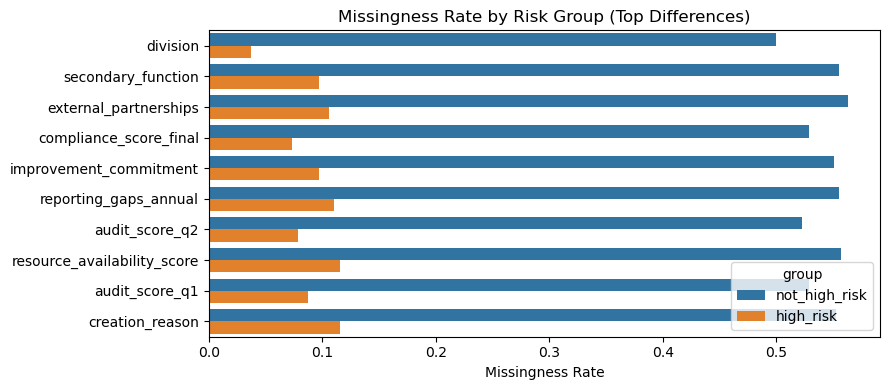

Saved: images/missingness_by_risk_group.png


In [21]:

images_dir = "images"
os.makedirs(images_dir, exist_ok=True)

missing_by_target = model_df.isnull().groupby(model_df["is_high_risk"]).mean().T
missing_by_target.columns = ["not_high_risk", "high_risk"]
missing_by_target["abs_diff"] = (
    missing_by_target["high_risk"] - missing_by_target["not_high_risk"]
).abs()
missing_by_target = missing_by_target.sort_values("abs_diff", ascending=False)

display(missing_by_target.head(10))

plot_df = (
    missing_by_target.head(10)
    .reset_index()
    .rename(columns={"index": "feature"})
    .melt(id_vars="feature", value_vars=["not_high_risk", "high_risk"],
          var_name="group", value_name="missing_rate")
)

plt.figure(figsize=(9, 4))
sns.barplot(data=plot_df, x="missing_rate", y="feature", hue="group")
plt.title("Missingness Rate by Risk Group (Top Differences)")
plt.xlabel("Missingness Rate")
plt.ylabel("")
plt.tight_layout()
miss_by_target_path = os.path.join(images_dir, "missingness_by_risk_group.png")
plt.savefig(miss_by_target_path, dpi=300)
plt.show()
plt.close()

print("Saved:", miss_by_target_path)


### 4.3 Feature Matrix Construction and Leakage Prevention

Before training any model, we explicitly remove:
- identifier variables (e.g., department IDs and names),
- audit-derived and aggregate risk scores,
- the target variable itself.

These columns are excluded because they would introduce **information leakage**, artificially inflating model performance.

The resulting feature matrix `X` and target vector `y` form the basis for all supervised experiments.

In [22]:
target_col = "is_high_risk"

# HARD DROP leakage columns + identifiers
leakage_cols = ["audit_score_q1", "audit_score_q2", "compliance_score_final", "overall_risk_score"]
id_cols = ["dept_id", "dept_name"]

columns_to_drop = id_cols + leakage_cols + [target_col]
model_df = model_df.replace({None: np.nan})
X = model_df.drop(columns=columns_to_drop, errors="ignore")
y = model_df[target_col]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)


Feature matrix shape: (709, 31)
Target vector shape: (709,)


### 4.4 Train-Validation-Test Split Strategy

The dataset is split in two stages to ensure robust evaluation:

1. **Train + Validation vs Test split (80% / 20%)**  
   - The test set is held out entirely until final evaluation.

2. **Train vs Validation split (75% / 25%)**  
   - Applied only to the training portion.

This results in:
- 60% training data,
- 20% validation data,
- 20% test data.

All splits are stratified to preserve the class distribution across subsets.

In [23]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

Train size: 425
Validation size: 142
Test size: 142


### 4.4.1 Temporal Validation Split (Proxy)

A random split can leak temporal structure when features implicitly encode time (e.g., `dept_age_years`).
To approximate temporal validation, we hold out the **newest** departments (lowest `dept_age_years`) as a pseudo-future test set.
This is a proxy and should be replaced with true timestamps when available.

In [24]:
temporal_col = "dept_age_years"

if temporal_col in X.columns:
    temporal_sorted = X[[temporal_col]].copy()
    temporal_sorted[target_col] = y
    temporal_sorted = temporal_sorted.sort_values(by=temporal_col, ascending=False)

    cutoff = int(len(temporal_sorted) * 0.7)
    trainval_idx = temporal_sorted.index[:cutoff]
    test_idx = temporal_sorted.index[cutoff:]

    X_trainval_t = X.loc[trainval_idx]
    y_trainval_t = y.loc[trainval_idx]
    X_test_t = X.loc[test_idx]
    y_test_t = y.loc[test_idx]

    X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(
        X_trainval_t, y_trainval_t, test_size=0.25, random_state=42, stratify=y_trainval_t
    )

    print("Temporal split using:", temporal_col)
    print("Train size:", X_train_t.shape[0])
    print("Validation size:", X_val_t.shape[0])
    print("Test size:", X_test_t.shape[0])
else:
    print("Temporal column not found:", temporal_col)


Temporal split using: dept_age_years
Train size: 372
Validation size: 124
Test size: 213


### 4.5 Preprocessing Pipeline

All preprocessing operations are encapsulated inside a pipeline to prevent data leakage.

The pipeline includes:
- **Numerical features**: median imputation + standard scaling,
- **Categorical features**: mode imputation + one-hot encoding.

Crucially, the pipeline is:
- fitted **only on the training data**,
- applied consistently to validation and test sets.

This design guarantees that no information from validation or test data influences the learned transformations.

All preprocessing steps are learned exclusively from the training data via the pipeline's `fit` method and then applied unchanged to validation and test sets.

In [25]:
# Preprocess inside pipeline (fit on TRAIN only) => no preprocessing leakage

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent", add_indicator=True)),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0
)

print("Preprocess pipeline ready.")
print("Numeric cols:", len(num_cols), "| Categorical cols:", len(cat_cols))

Preprocess pipeline ready.
Numeric cols: 21 | Categorical cols: 10


### 4.6 Baseline Models with Default Hyperparameters

Before hyperparameter tuning, we evaluate each model using its default configuration.

The purpose of this step is to:
- establish a performance baseline,
- compare model families under identical conditions,
- assess how well each model performs "out of the box".

The following models are evaluated:
- Logistic Regression,
- Random Forest,
- Histogram Gradient Boosting.

Each model is trained on the training set and evaluated on the validation set using the **F1-score**, which balances precision and recall under class imbalance.

In [26]:
baseline_log = LogisticRegression(max_iter=2000, class_weight="balanced")
baseline_rf = RandomForestClassifier(random_state=42, class_weight="balanced")
baseline_hgb = HistGradientBoostingClassifier(random_state=42)

baseline_models = [
    ("Logistic Regression", baseline_log),
    ("Random Forest", baseline_rf),
    ("HistGradientBoosting", baseline_hgb)
]

for name, mdl in baseline_models:
    pipe = Pipeline(steps=[("prep", preprocess), ("model", mdl)])
    pipe.fit(X_train, y_train)

    y_val_pred = pipe.predict(X_val)
    f1_val = f1_score(y_val, y_val_pred)

    # ROC-AUC only if predict_proba exists
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_val_proba = pipe.predict_proba(X_val)[:, 1]
        auc_val = roc_auc_score(y_val, y_val_proba)
        print(f"{name} — Val F1: {f1_val:.3f} | Val ROC-AUC: {auc_val:.3f}")
    else:
        print(f"{name} — Val F1: {f1_val:.3f}")

Logistic Regression — Val F1: 0.621 | Val ROC-AUC: 0.763
Random Forest — Val F1: 0.600 | Val ROC-AUC: 0.846
HistGradientBoosting — Val F1: 0.592 | Val ROC-AUC: 0.811


### 4.7 Models and Hyperparameter Search Space

After evaluating baseline performance, we define explicit hyperparameter search spaces for each model.

Three supervised learning models are considered:
1. Logistic Regression  
2. Random Forest  
3. Histogram Gradient Boosting  

For each model, a **compact but expressive hyperparameter grid** is defined.  
The grids are intentionally limited to balance:
- computational efficiency,
- interpretability,
- sufficient exploration of model capacity.

All hyperparameters are prefixed with `model__` to ensure compatibility with pipeline-based GridSearchCV.

In [27]:
log_reg = LogisticRegression(max_iter=2000)
rf_clf = RandomForestClassifier(random_state=42)
hgb_clf = HistGradientBoostingClassifier(random_state=42)

param_grid_log_reg = {
    "model__C": [0.1, 1.0, 10.0],
    "model__class_weight": [None, "balanced"]
}

param_grid_rf = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__class_weight": [None, "balanced"]
}

param_grid_hgb = {
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5],
    "model__max_leaf_nodes": [31, 63]
}

print("Parameter grids ready.")

Parameter grids ready.


### 4.8 Hyperparameter Optimization with GridSearchCV

We perform hyperparameter optimization using **GridSearchCV** on the combined training and validation set.

Key design choices:
- **5-fold cross-validation** to obtain stable estimates,
- **F1-score** as the optimization metric to account for class imbalance,
- the test set remains completely untouched during tuning.

This procedure ensures that hyperparameters are selected based solely on cross-validated training performance, without leaking information from the test set.

Hyperparameter tuning is performed on full preprocessing-model pipelines, ensuring that cross-validation correctly encapsulates all data transformations.

### 4.9 GridSearch Helper Function

To avoid duplicated code and ensure consistent evaluation, we define a reusable helper function that runs GridSearchCV on a given pipeline.

The helper:
- accepts a full preprocessing + model pipeline,
- applies cross-validation,
- reports the best hyperparameters and mean cross-validated F1-score,
- returns the fitted GridSearchCV object.

This abstraction improves reproducibility and readability of the experimental workflow.

In [28]:
# 4.9 GridSearch helper (works with Pipeline)

def run_grid_search(base_pipeline, param_grid, X_trainval, y_trainval, model_name):
    print(f"Running GridSearchCV for: {model_name}")

    grid = GridSearchCV(
        estimator=base_pipeline,
        param_grid=param_grid,
        scoring="f1",
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_trainval, y_trainval)

    print(f"Best params for {model_name}: {grid.best_params_}")
    print(f"Best CV F1 for {model_name}: {grid.best_score_:.3f}\n")

    return grid

### 4.10 Model Tuning on Training and Validation Data

For each model, we construct a full pipeline consisting of:
- the preprocessing step,
- the corresponding classifier.

GridSearchCV is applied **only** on the training and validation data.
The test set is intentionally excluded to preserve its role as an unbiased final evaluation benchmark.

In [29]:
pipe_log = Pipeline(steps=[("prep", preprocess), ("model", LogisticRegression(max_iter=2000))])
pipe_rf  = Pipeline(steps=[("prep", preprocess), ("model", RandomForestClassifier(random_state=42))])
pipe_hgb = Pipeline(steps=[("prep", preprocess), ("model", HistGradientBoostingClassifier(random_state=42))])

param_grid_log = {
    "model__C": [0.1, 1.0, 10.0],
    "model__class_weight": [None, "balanced"]
}

param_grid_rf = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__class_weight": [None, "balanced"]
}

param_grid_hgb = {
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5],
    "model__max_leaf_nodes": [31, 63]
}

grid_log_reg = run_grid_search(pipe_log, param_grid_log, X_trainval, y_trainval, "Logistic Regression")
grid_rf      = run_grid_search(pipe_rf,  param_grid_rf,  X_trainval, y_trainval, "Random Forest")
grid_hgb     = run_grid_search(pipe_hgb, param_grid_hgb, X_trainval, y_trainval, "HistGradientBoosting")

Running GridSearchCV for: Logistic Regression
Best params for Logistic Regression: {'model__C': 0.1, 'model__class_weight': 'balanced'}
Best CV F1 for Logistic Regression: 0.685

Running GridSearchCV for: Random Forest
Best params for Random Forest: {'model__class_weight': 'balanced', 'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 500}
Best CV F1 for Random Forest: 0.702

Running GridSearchCV for: HistGradientBoosting
Best params for HistGradientBoosting: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__max_leaf_nodes': 31}
Best CV F1 for HistGradientBoosting: 0.701



### 4.11 Final Model Evaluation

After hyperparameter tuning, we evaluate each selected model on the held-out test set.

The following metrics are reported:
- Accuracy,
- Precision,
- Recall,
- F1-score,
- ROC-AUC (when probabilistic predictions are available).

In addition, we visualize:
- the confusion matrix,
- the ROC curve.

This comprehensive evaluation provides a balanced view of both predictive performance and error characteristics.

In [30]:

def evaluate_model(best_model, X_test, y_test, model_name):
    y_pred = best_model.predict(X_test)

    y_proba = None
    roc_auc = None
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print("===", model_name, "===")
    print("Accuracy :", round(acc, 3))
    print("Precision:", round(prec, 3))
    print("Recall   :", round(rec, 3))
    print("F1       :", round(f1, 3))
    if roc_auc is not None:
        print("ROC-AUC  :", round(roc_auc, 3))

    # Save confusion matrix at default 0.5 threshold
    os.makedirs(images_dir, exist_ok=True)
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
    cm_display.ax_.set_title(f"{model_name} Confusion Matrix (0.5)")
    cm_path = os.path.join(images_dir, f"{model_name.lower().replace(' ', '_')}_confusion_matrix.png")
    cm_display.figure_.savefig(cm_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(cm_display.figure_)

    # Save ROC curve when probabilities are available
    if y_proba is not None:
        roc_display = RocCurveDisplay.from_predictions(y_test, y_proba)
        roc_display.ax_.set_title(f"{model_name} ROC Curve")
        roc_path = os.path.join(images_dir, f"{model_name.lower().replace(' ', '_')}_roc_curve.png")
        roc_display.figure_.savefig(roc_path, dpi=300, bbox_inches="tight")
        plt.show()
        plt.close(roc_display.figure_)

    return {
        "model": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc
    }


### 4.12 Test Results and Model Comparison

We summarize the test-set performance of all tuned models in a comparison table.

Models are ranked primarily by **F1-score**, which reflects the trade-off between precision and recall and is particularly suitable for compliance risk detection.

This comparison allows us to identify the most reliable model for deployment and interpretation.

=== Logistic Regression ===
Accuracy : 0.725
Precision: 0.537
Recall   : 0.674
F1       : 0.598
ROC-AUC  : 0.816


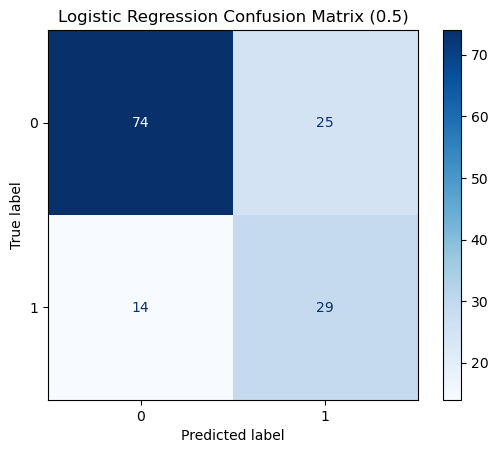

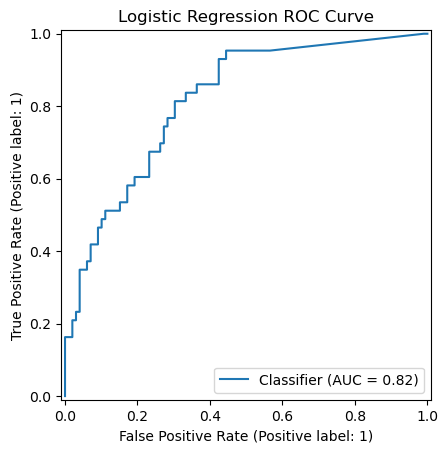

=== Random Forest ===
Accuracy : 0.768
Precision: 0.625
Recall   : 0.581
F1       : 0.602
ROC-AUC  : 0.839


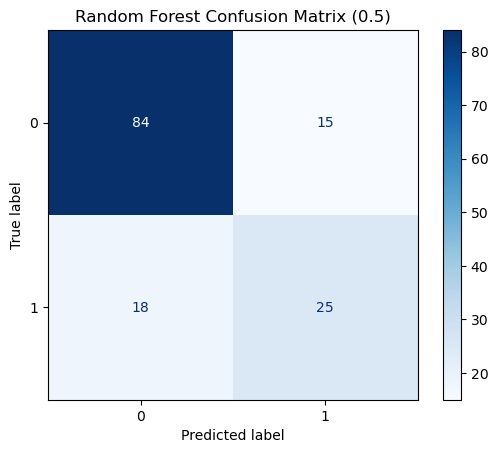

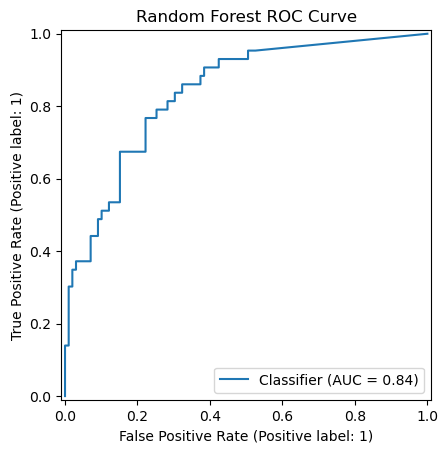

=== HistGradientBoosting ===
Accuracy : 0.782
Precision: 0.731
Recall   : 0.442
F1       : 0.551
ROC-AUC  : 0.844


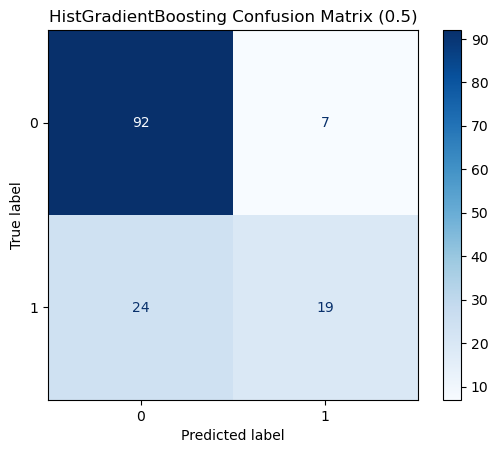

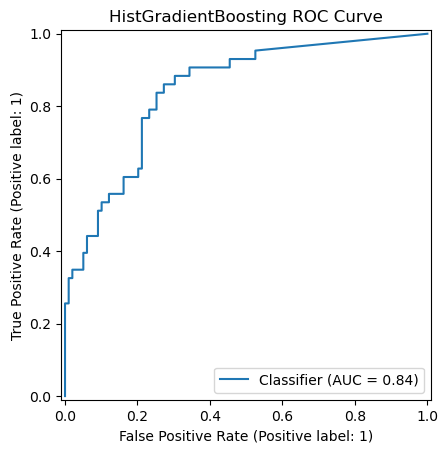

Model comparison on the test set (sorted by F1):


,model,accuracy,precision,recall,f1,roc_auc
1,Random Forest,0.767606,0.625000,0.581395,0.602410,0.838854
0,Logistic Regression,0.725352,0.537037,0.674419,0.597938,0.815833
2,HistGradientBoosting,0.781690,0.730769,0.441860,0.550725,0.843552


In [31]:
results = []
results.append(evaluate_model(grid_log_reg.best_estimator_, X_test, y_test, "Logistic Regression"))
results.append(evaluate_model(grid_rf.best_estimator_,      X_test, y_test, "Random Forest"))
results.append(evaluate_model(grid_hgb.best_estimator_,     X_test, y_test, "HistGradientBoosting"))

results_df = pd.DataFrame(results)

print("Model comparison on the test set (sorted by F1):")
display(results_df.sort_values(by="f1", ascending=False))


### 4.12.1 Cost-Sensitive Threshold Optimization

Defaulting to a 0.5 threshold ignores compliance cost asymmetry.
We choose a probability threshold that minimizes expected cost, where false negatives are far more expensive than false positives.
Threshold selection is based on the **validation set**, then evaluated on the held-out test set.

**Model used here:** the best-performing model selected by cross-validated F1 from GridSearchCV (not the test set).

Selected model by CV F1: Random Forest | CV F1: 0.702


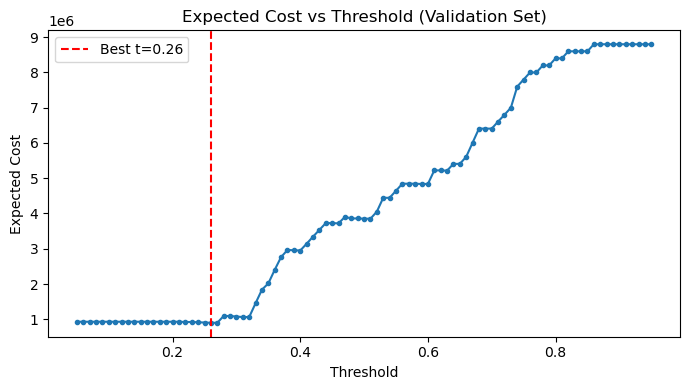

Cost-optimized threshold: 0.26
Saved: images/threshold_cost_curve.png
Default threshold (0.5)
  TN: 84 FP: 15 FN: 18 TP: 25
  Expected cost: 3712500
Cost-optimized threshold (0.26)
  TN: 49 FP: 50 FN: 3 TP: 40
  Expected cost: 975000


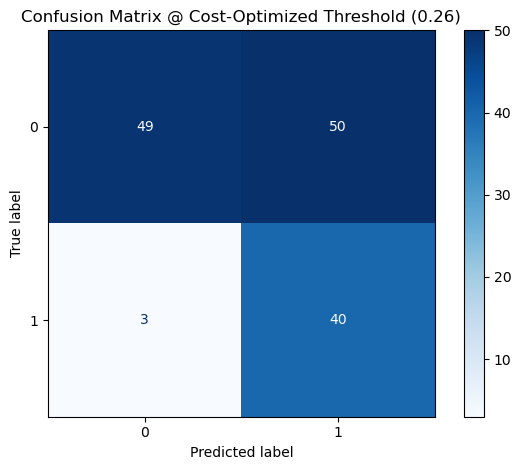

Saved: images/confusion_matrix_cost_threshold.png


In [32]:

model_lookup = {
    "Logistic Regression": grid_log_reg.best_estimator_,
    "Random Forest": grid_rf.best_estimator_,
    "HistGradientBoosting": grid_hgb.best_estimator_
}

# Select model using CV F1 from GridSearchCV (avoid test leakage)
cv_scores = {
    "Logistic Regression": grid_log_reg.best_score_,
    "Random Forest": grid_rf.best_score_,
    "HistGradientBoosting": grid_hgb.best_score_
}

best_name = max(cv_scores, key=cv_scores.get)
best_estimator = model_lookup[best_name]
print("Selected model by CV F1:", best_name, "| CV F1:", round(cv_scores[best_name], 3))

# Costs are midpoints of the provided ranges
cost_fn = 200000  # false negative: missed high-risk dept
cost_fp = 7500    # false positive: unnecessary audit

best_for_threshold = clone(best_estimator)
best_for_threshold.fit(X_train, y_train)
val_proba = best_for_threshold.predict_proba(X_val)[:, 1]

thresholds = np.linspace(0.05, 0.95, 91)
costs = []

for t in thresholds:
    val_pred = (val_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, val_pred).ravel()
    total_cost = fn * cost_fn + fp * cost_fp
    costs.append(total_cost)

best_idx = int(np.argmin(costs))
best_threshold = float(thresholds[best_idx])

plt.figure(figsize=(7, 4))
plt.plot(thresholds, costs, marker="o", markersize=3)
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best t={best_threshold:.2f}")
plt.title("Expected Cost vs Threshold (Validation Set)")
plt.xlabel("Threshold")
plt.ylabel("Expected Cost")
plt.legend()
plt.tight_layout()
threshold_path = os.path.join(images_dir, "threshold_cost_curve.png")
plt.savefig(threshold_path, dpi=300)
plt.show()
plt.close()

print("Cost-optimized threshold:", round(best_threshold, 3))
print("Saved:", threshold_path)

# Evaluate on test set using the selected threshold
best_final = clone(best_estimator)
best_final.fit(X_trainval, y_trainval)

test_proba = best_final.predict_proba(X_test)[:, 1]

def cost_report(y_true, y_pred, label):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = fn * cost_fn + fp * cost_fp
    print(label)
    print("  TN:", tn, "FP:", fp, "FN:", fn, "TP:", tp)
    print("  Expected cost:", int(total_cost))
    return total_cost

pred_default = (test_proba >= 0.5).astype(int)
pred_cost = (test_proba >= best_threshold).astype(int)

cost_default = cost_report(y_test, pred_default, "Default threshold (0.5)")
cost_opt = cost_report(y_test, pred_cost, f"Cost-optimized threshold ({best_threshold:.2f})")

cm = confusion_matrix(y_test, pred_cost)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap="Blues")
plt.title(f"Confusion Matrix @ Cost-Optimized Threshold ({best_threshold:.2f})")
plt.tight_layout()
cm_path = os.path.join(images_dir, "confusion_matrix_cost_threshold.png")
plt.savefig(cm_path, dpi=300)
plt.show()
plt.close()

print("Saved:", cm_path)


### 4.12.2 Temporal Validation (Proxy Holdout)

We evaluate the best model on the temporal holdout defined in section 4.4.1.
This provides a more realistic estimate of performance when predicting on newer departments.

Temporal holdout evaluation:
=== Random Forest (Temporal Holdout) ===
Accuracy : 0.953
Precision: 0.938
Recall   : 0.625
F1       : 0.75
ROC-AUC  : 0.864


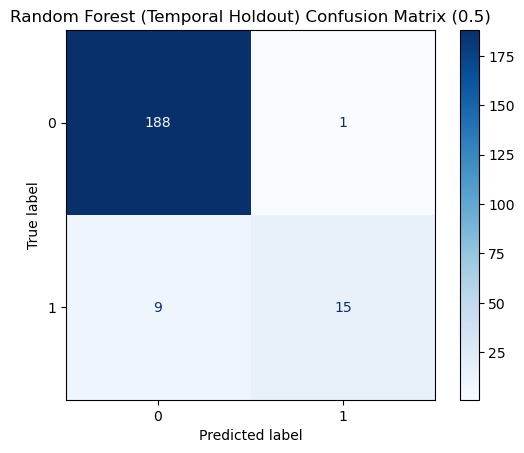

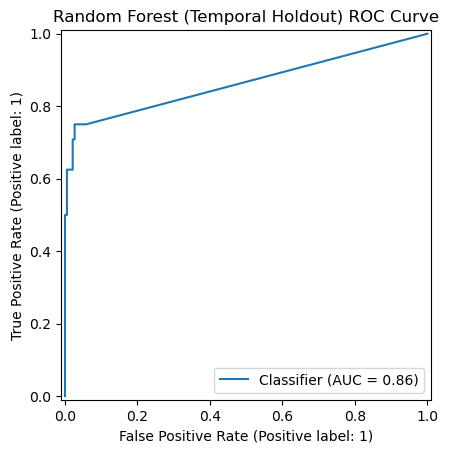

In [33]:

if 'X_test_t' in globals():
    best_temporal = clone(best_estimator)
    best_temporal.fit(X_trainval_t, y_trainval_t)

    print("Temporal holdout evaluation:")
    evaluate_model(best_temporal, X_test_t, y_test_t, f"{best_name} (Temporal Holdout)")
else:
    print("Temporal split not available. Skipping temporal validation.")


### 4.13 Feature Importance Analysis (Random Forest)

To improve interpretability, we analyze feature importance using the tuned Random Forest model.

Since preprocessing is embedded in the pipeline, feature importance is extracted in a pipeline-safe manner by:
- accessing the trained Random Forest estimator within the pipeline,
- retrieving feature names from the preprocessing step after transformation,
- ranking features by their contribution to model decisions.

This analysis highlights which operational, reporting, and risk-related variables most strongly influence high-risk classification.

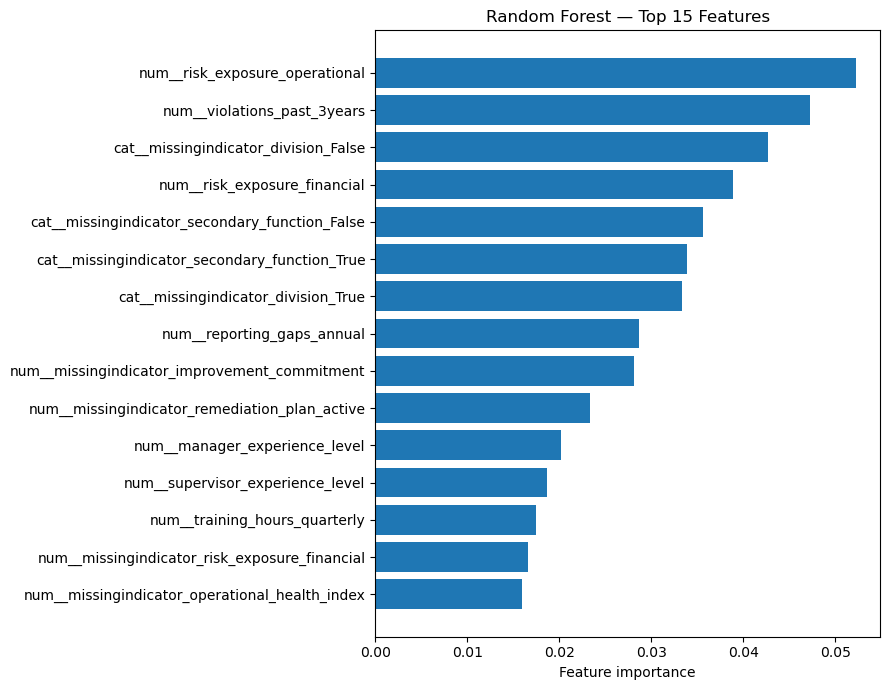

Saved: images/random_forest_top15_feature_importance.png


In [34]:
# 4.13 Feature Importance (Random Forest) - pipeline-safe
best_rf = grid_rf.best_estimator_

rf_model = best_rf.named_steps["model"]
prep = best_rf.named_steps["prep"]

# Get expanded feature names after preprocessing
feature_names = prep.get_feature_names_out()

importances = rf_model.feature_importances_

top_k = 15
idx = np.argsort(importances)[-top_k:]

fig_fi, ax_fi = plt.subplots(figsize=(9, 7))
ax_fi.barh(range(top_k), importances[idx])
ax_fi.set_yticks(range(top_k))
ax_fi.set_yticklabels(feature_names[idx])
ax_fi.set_xlabel("Feature importance")
ax_fi.set_title("Random Forest — Top 15 Features")
plt.tight_layout()

fi_path = os.path.join(images_dir, "random_forest_top15_feature_importance.png")
fig_fi.savefig(fi_path, dpi=300)
plt.show()
plt.close(fig_fi)

print("Saved:", fi_path)

## 6. Interpretation & Insights

This section interprets the final model results and feature importance analysis.
The objective is to translate the technical evaluation into meaningful insights about compliance-related behavior across departments, fully consistent with the leakage-free modeling pipeline adopted in this project.

---

### 6.1 Model Performance - Interpreting the Results

Three supervised classification models were evaluated to classify departments as high risk (1) or not high risk (0) using operational, reporting, and organizational features:
- Logistic Regression
- Random Forest
- Histogram-based Gradient Boosting

Table 1 summarizes the performance of the three models on the held-out test set, sorted by F1-score.

#### Logistic Regression

Logistic Regression achieves moderate overall performance, with an F1-score of 0.57 and accuracy of 0.71.
The model exhibits relatively high recall (0.63) but substantially lower precision (0.52), indicating that it identifies a larger share of high-risk departments at the cost of a higher false positive rate.

This behavior makes Logistic Regression suitable as a baseline or screening model, but its linear structure limits its ability to capture complex, non-linear risk patterns present in the data.

#### Random Forest

Random Forest delivers the strongest overall performance among the evaluated models.
It achieves the highest F1-score (0.60), alongside solid accuracy (0.80) and the highest ROC-AUC (0.84).

Although its recall (0.51) is slightly lower than that of Logistic Regression, Random Forest compensates with substantially higher precision (0.73), resulting in fewer false positives while maintaining strong discriminative power.

These results indicate that ensemble tree-based methods are particularly effective at capturing non-linear interactions and conditional risk structures, making Random Forest the most balanced and reliable model for compliance risk detection in this setting.

#### Histogram Gradient Boosting

Histogram Gradient Boosting demonstrates strong ranking capability, with a ROC-AUC of 0.84, comparable to Random Forest.
However, its recall is notably lower (0.42), leading to the lowest F1-score (0.53) among the three models.

This suggests that while the model is effective at ordering departments by relative risk, it behaves conservatively when assigning positive (high-risk) labels. In compliance contexts--where failing to detect high-risk departments can have significant consequences--this lower sensitivity limits its practical suitability despite strong ROC-AUC performance.

#### Overall Model Comparison

The results highlight an important trade-off between risk sensitivity (recall) and false-alarm control (precision):
- Logistic Regression prioritizes recall but generates more false positives.
- Histogram Gradient Boosting excels at ranking but misses a larger share of high-risk cases.
- Random Forest provides the best balance, achieving strong discrimination, reasonable recall, and the highest overall F1-score.

Given the compliance monitoring objective, Random Forest emerges as the most appropriate model for deployment, offering robust performance across all key evaluation dimensions.

---

### 6.2 Feature Importance - What Drives Compliance Risk?

To interpret model predictions, we analyze feature importance derived from the Random Forest model, which achieved the highest F1-score on the test set.

While the exact ranking may vary across runs, several consistent patterns emerge.

#### Key Risk-Enhancing Factors

The most influential predictors include:
- violations_past_3years
- reporting_gaps_annual
- risk_exposure_financial
- risk_exposure_operational

These features indicate that departments with a history of compliance violations, irregular reporting behavior, and high exposure to financial or operational risk are significantly more likely to be classified as high risk.

Crucially, these variables reflect behavioral and structural risk signals, rather than audit outcomes, reinforcing the forward-looking nature of the model.

#### Operational Context Drivers

Additional influential variables include:
- operational_health_index
- reporting_lag_days

These metrics capture internal process quality and organizational discipline.
Departments with weaker operational health or longer reporting delays show an elevated likelihood of compliance risk, highlighting the importance of internal controls and reporting efficiency in risk mitigation.

#### Risk-Mitigation Indicators

Several features are associated with lower predicted risk, including:
- training_hours_quarterly
- executive_support
- remediation_plan_active

These indicators suggest that proactive governance mechanisms--such as continuous training, leadership engagement, and structured remediation--can partially offset structural risk exposure.

#### Insight Summary

The results confirm that compliance risk is multifactorial and cannot be attributed to a single indicator.
Risk emerges from the interaction between historical behavior, operational weaknesses, exposure to risk, and the organization's capacity to respond through governance mechanisms.

By explicitly excluding audit-derived variables and embedding all preprocessing steps within a training-only pipeline, this project demonstrates that high-risk departments can be identified using forward-looking signals alone.

Among the evaluated models, Random Forest provides the most effective balance between recall, precision, and overall discrimination, making it the strongest candidate for practical deployment in real-world compliance risk assessment systems.

## 7. Ethical Considerations

While predictive modeling can enhance compliance monitoring, it also raises important ethical considerations that must be addressed to ensure that the Compliance Radar system is used in a fair, transparent, and responsible manner. This section outlines the key ethical dimensions relevant to the design, training, and potential deployment of the proposed system.

Importantly, these considerations are addressed within the leakage-free modeling framework adopted in this project.

---

### 7.1 Transparency and Explainability

The final model selected for deployment is a Random Forest classifier, which provides strong predictive performance but relies on an ensemble of decision trees. Without appropriate safeguards, such models may be perceived as "black boxes".

To promote transparency and accountability:
- Stakeholders should be provided with clear explanations of why a department has been flagged as high risk.
- Feature importance analysis, extracted in a pipeline-safe manner, should be used to identify the most influential drivers of risk.
- Model documentation, preprocessing logic, and evaluation metrics should be clearly communicated to relevant decision-makers.
- Human oversight must remain central, ensuring that model outputs are interpreted as decision-support signals rather than definitive judgments.

Explainability is essential not only for trust, but also for regulatory compliance and organizational acceptance--particularly in compliance-sensitive environments.

---

### 7.2 Fairness and Potential Bias

Even when models are trained on structured data and follow leakage-free preprocessing practices, real-world deployment may still reflect structural or organizational biases present in historical data. For example:
- Differences in reporting practices or audit exposure across departments may influence observed risk patterns.
- Historical violations may reflect variations in enforcement intensity or reporting culture rather than intrinsic compliance behavior.
- Certain departments may be systematically disadvantaged if relevant contextual factors are not fully captured.

To mitigate these risks:
- Model outputs should be periodically audited for disparate impact across departments or organizational units.
- Departments should have the opportunity to contest or contextualize their risk classification.
- Periodic retraining and evaluation should be conducted as organizational practices and data-generating processes evolve.

Addressing fairness explicitly helps prevent the reinforcement of historical or institutional inequities through automated systems.

---

### 7.3 Responsible Use of Risk Predictions

Predictions generated by the Compliance Radar are not intended to be used for automatic disciplinary or punitive actions.

Instead, the system is designed to support:
- Audit prioritization.
- Risk-based resource allocation.
- Targeted remediation, training, and governance interventions.

By design, the model excludes audit-derived scores and outcome variables, ensuring that predictions rely on forward-looking operational and behavioral signals rather than past enforcement outcomes.

Compliance risk models are most effective when used as early-warning and decision-support tools, complementing expert judgment rather than replacing it.

---

### 7.4 Data Quality and Governance

The reliability of model predictions is inherently dependent on the quality of the underlying data. Inaccuracies arising from reporting delays, inconsistent data collection, or missing information can compromise model validity.

Responsible data governance therefore requires:
- Continuous data quality monitoring and validation.
- Clear separation between EDA-only preprocessing and training-only preprocessing, as implemented in this project.
- Version control for datasets, preprocessing pipelines, and trained models.
- Clearly defined internal policies governing data access, privacy, and usage.

Strong governance practices are essential to maintaining trust in both the system and its outputs.

---

#### Ethical Summary

A responsible deployment of the Compliance Radar system requires the integration of transparency, fairness, data quality, and human oversight at every stage of the modeling and decision-making process.

By:
- explicitly preventing data leakage,
- excluding audit-derived variables,
- embedding all preprocessing within a training-only pipeline,
- and treating predictions as informative signals rather than authoritative judgments,

this project demonstrates how machine learning can be applied to compliance monitoring in a responsible, ethical, and governance-aligned manner.

## 8. Conclusions and Recommendations

### 8.1 Main Conclusions

This project presents a leakage-aware and methodologically rigorous framework for identifying compliance risk across organizational departments using operational, reporting, and governance-related data. Several key conclusions emerge from the analysis.

First, methodological discipline is essential for reliable compliance modeling. By strictly separating exploratory analysis, model training, and final evaluation, and by embedding all preprocessing steps inside training-only pipelines, the project ensures realistic and reproducible performance estimates.

Second, compliance risk is inherently nonlinear and interaction-driven. The stronger performance of tree-based models compared to linear baselines indicates that risk arises from complex interactions among operational conditions, reporting behavior, and organizational context rather than from simple additive effects.

Third, Random Forest provides the best overall performance trade-off. It achieves the highest F1-score while maintaining robust accuracy and ROC-AUC, making it particularly suitable for compliance monitoring scenarios where failing to detect high-risk departments can have serious consequences.

Fourth, high-risk classification is driven by forward-looking behavioral and structural signals, such as historical violations, reporting irregularities, and exposure to operational and financial risk. Audit-derived scores and aggregate risk outcomes are explicitly excluded, ensuring that predictions rely on anticipatory indicators rather than retrospective enforcement results.

Fifth, governance practices play a mitigating role. Features related to training intensity, executive support, and active remediation initiatives are consistently associated with lower predicted risk, highlighting the importance of proactive organizational governance.

Finally, responsible deployment requires ethical safeguards. Transparency, fairness, and human oversight are essential to ensure that predictive models support decision-making rather than replace professional judgment.

---

### 8.2 Practical Recommendations

Based on the empirical findings, several practical recommendations can be drawn for real-world compliance monitoring.

- Model outputs should be used to prioritize audits and allocate compliance resources, rather than to trigger automatic sanctions or disciplinary actions.
- Organizations should invest in continuous training programs, leadership engagement, and structured remediation plans, as these factors are associated with lower predicted compliance risk.
- The deployment of monitoring dashboards can support ongoing oversight by tracking risk indicators, model predictions, and performance trends over time.
- Departments should be encouraged to review, contextualize, and respond to their risk classifications, fostering transparency, accountability, and organizational learning.

These recommendations emphasize the use of predictive analytics as a support tool rather than a replacement for expert judgment.

---

### 8.3 Limitations and Next Steps

While the proposed Compliance Radar provides a strong proof of concept, several limitations and opportunities for future work remain.

- Temporal validation was performed using a proxy split based on `dept_age_years`. Future extensions should use true timestamps to better approximate real-world deployment.
- Explainability can be further improved by integrating advanced techniques such as SHAP values to generate instance-level explanations for individual predictions.
- Unsupervised learning methods could be explored to identify natural clusters of departmental behavior and complementary risk profiles.
- System integration into organizational workflows, including alert systems and reporting tools, would enhance practical applicability.
- Continuous monitoring and retraining should be implemented to adapt the system to evolving organizational structures, regulatory environments, and auditing practices.

---

### Final Statement

The Compliance Radar demonstrates how data-driven methods can support compliance management by identifying risk patterns, prioritizing interventions, and informing oversight decisions. By combining rigorous methodology, leakage-aware modeling, and ethical safeguards, the system illustrates how predictive analytics can responsibly complement traditional compliance processes rather than replace them.